In [1]:
import numpy as np
import pandas as pd

In [2]:
import consts
import util

In [3]:
dataset = pd.read_csv('data/arc_ms_spec_ordered.csv', index_col=0)
dataset

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,...,273,322,1,314,317,318,319,320,300,0
107,0,0,0,0,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372353,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5372813,0,0,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5373729,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6040503,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
possible_target_cols = consts.POSSIBLE_TARGET_COLS
target_cols = consts.TARGET_COLS
# target_cols = possible_target_cols
target_cols

array(['Herbal', 'Green', 'Woody', 'Sweet', 'Balsamic', 'Earth', 'Spicy'],
      dtype='<U8')

In [5]:
# feature_cols = dataset.columns[possible_target_cols.shape[0]:possible_target_cols.shape[0]+consts.ZERO_NUM_FEATURE_COLS_999]
# feature_cols = dataset.columns[possible_target_cols.shape[0]:possible_target_cols.shape[0]+326]
# feature_cols = dataset.columns[possible_target_cols.shape[0]:]

# feature_cols = dataset.columns[possible_target_cols.shape[0]:]
feature_cols = dataset.columns[possible_target_cols.shape[0]:possible_target_cols.shape[0]+194]
feature_cols

Index(['43', '41', '57', '91', '55', '69', '71', '105', '56', '81',
       ...
       '268', '304', '285', '49', '183', '186', '48', '35', '37', '188'],
      dtype='object', length=194)

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from hypll import nn as hnn
from hypll.tensors import TangentTensor

# Define your MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers, manifold):
        super(MLP, self).__init__()
        torch.manual_seed(consts.TORCH_MANUAL_SEED)
        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_out = hnn.HLinear(layer_size, output_size, manifold=manifold)
        # self.sigmoid = nn.Sigmoid()  # Sigmoid activation for multi-label classification

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)
        # x = self.sigmoid(x)  # Sigmoid activation for multi-label classification
        return x

# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define training function
def train_model(model, train_loader, criterion, optimizer, manifold, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        outputs = model(manifold_inputs)

        loss = criterion(outputs.tensor, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [7]:
# num_hidden_layers = 2
# layer_size = 256
# lr = 0.001
# weight_decay = 0.01 # [0, 0.001]
# batch_size = 128  # [64, 80, 94]
# BCE_weights_power = 0.5
# BCE_weights_factor = 1.2
# epochs = 100
# curvature  = -1
num_hidden_layers = 1
layer_size = 128
lr = 0.001
weight_decay = 0.005 # [0, 0.001]
batch_size = 96  # [64, 80, 94]
BCE_weights_power = 0.5
BCE_weights_factor = 1.2
epochs = 40
curvature  = -1

In [8]:
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

# Prepare data
positive_dataset = dataset.loc[(dataset[target_cols] != 0).any(axis=1)]
features = positive_dataset[feature_cols].apply(util.normalize_column, axis=0).fillna(0).values
labels = positive_dataset[target_cols].values

manifold = PoincareBall(c=Curvature(curvature))

THRESHOLDS = [0.55, 0.6, 0.65, 0.7]

METRICS = ['acc', 'hamm', 'prec', 'sens', 'f1', 'aps']

eval_stats = {'loss': {'train': [], 'val': []}}
for metric in METRICS:
    eval_stats[metric] = {'train': {t: [] for t in THRESHOLDS},
                          'val': {t: [] for t in THRESHOLDS}}

# Initialize cross-validation
kf = KFold(n_splits=consts.KFOLDS, shuffle=True, random_state=consts.KFOLD_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an empty list to store parameters
all_model_params = []
# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(features, labels)):
    print(f'Fold {fold + 1}')

    # Split data into train and validation sets
    train_features, val_features = features[train_idx], features[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create DataLoader for training and validation
    train_dataset = CustomDataset(train_features, train_labels)
    val_dataset = CustomDataset(val_features, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = MLP(input_size=len(feature_cols), output_size=len(target_cols), layer_size=layer_size, num_hidden_layers=num_hidden_layers, manifold=manifold).to(device)

    # criterion = nn.BCELoss()
    # criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones_like(bce_positive_weights))

    possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())
    indices = np.where(np.isin(possible_target_cols, target_cols))[0]
    label_occurences = possible_label_occurences[indices]

    bce_positive_weights = util.calc_bce_positive_weights(label_occurences, BCE_weights_power, BCE_weights_factor)

    print(bce_positive_weights)
    criterion = nn.BCEWithLogitsLoss(pos_weight=bce_positive_weights)


    optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    eval_stats_fold = {'loss': {'train': [], 'val': []}}
    for metric in METRICS:
        eval_stats_fold[metric] = {'train': {t: [] for t in THRESHOLDS},
                            'val': {t: [] for t in THRESHOLDS}}

    for epoch in tqdm(range(epochs), desc="Epoch"):
        eval_stats_fold['loss']['train'].append(train_model(model, train_loader, criterion, optimizer, manifold, device))
        eval_stats_fold['loss']['val'].append(util.h_evaluate_loss(model, val_loader, criterion, manifold, device))

        # Calculate and store specuracy
        # accuracy, hamm, precision, sensitivity, f1, aps
        for t in THRESHOLDS:
            eval_train = util.h_evaluate_metrics(model, train_loader, manifold, device, t)
            eval_val = util.h_evaluate_metrics(model, val_loader, manifold, device, t)
            for i, metric in enumerate(METRICS):
                eval_stats_fold[metric]['train'][t].append(eval_train[i])
                eval_stats_fold[metric]['val'][t].append(eval_val[i])

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {eval_stats_fold['loss']['train'][-1]:.4f}, Val Loss: {eval_stats_fold['loss']['val'][-1]:.4f}")

    eval_stats['loss']['train'].append(eval_stats_fold['loss']['train'])
    eval_stats['loss']['val'].append(eval_stats_fold['loss']['val'])
    for metric in METRICS:
        for t in THRESHOLDS:
            eval_stats[metric]['train'][t].append(eval_stats_fold[metric]['train'][t])
            eval_stats[metric]['val'][t].append(eval_stats_fold[metric]['val'][t])

    # Append parameters of the trained model
    all_model_params.append(model.state_dict())


Fold 1
tensor([3.2361, 3.5060, 4.3122, 3.7526, 5.6460, 5.9478, 5.9118],
       dtype=torch.float64)


/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_22163/1958821669.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1461, Val Loss: 1.2007
Epoch 2/40, Train Loss: 1.1232, Val Loss: 1.1928
Epoch 3/40, Train Loss: 1.1085, Val Loss: 1.1873
Epoch 4/40, Train Loss: 1.0973, Val Loss: 1.1831
Epoch 5/40, Train Loss: 1.0881, Val Loss: 1.1800
Epoch 6/40, Train Loss: 1.0804, Val Loss: 1.1774
Epoch 7/40, Train Loss: 1.0736, Val Loss: 1.1750
Epoch 8/40, Train Loss: 1.0672, Val Loss: 1.1732
Epoch 9/40, Train Loss: 1.0612, Val Loss: 1.1718
Epoch 10/40, Train Loss: 1.0555, Val Loss: 1.1705
Epoch 11/40, Train Loss: 1.0501, Val Loss: 1.1693
Epoch 12/40, Train Loss: 1.0449, Val Loss: 1.1680
Epoch 13/40, Train Loss: 1.0400, Val Loss: 1.1669
Epoch 14/40, Train Loss: 1.0351, Val Loss: 1.1658
Epoch 15/40, Train Loss: 1.0303, Val Loss: 1.1647
Epoch 16/40, Train Loss: 1.0253, Val Loss: 1.1639
Epoch 17/40, Train Loss: 1.0206, Val Loss: 1.1629
Epoch 18/40, Train Loss: 1.0158, Val Loss: 1.1621
Epoch 19/40, Train Loss: 1.0110, Val Loss: 1.1614
Epoch 20/40, Train Loss: 1.0061, Val Loss: 1.1607
Epoch 21/

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_22163/1958821669.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1583, Val Loss: 1.1512
Epoch 2/40, Train Loss: 1.1365, Val Loss: 1.1405
Epoch 3/40, Train Loss: 1.1226, Val Loss: 1.1315
Epoch 4/40, Train Loss: 1.1113, Val Loss: 1.1251
Epoch 5/40, Train Loss: 1.1028, Val Loss: 1.1199
Epoch 6/40, Train Loss: 1.0955, Val Loss: 1.1160
Epoch 7/40, Train Loss: 1.0892, Val Loss: 1.1128
Epoch 8/40, Train Loss: 1.0834, Val Loss: 1.1099
Epoch 9/40, Train Loss: 1.0780, Val Loss: 1.1070
Epoch 10/40, Train Loss: 1.0726, Val Loss: 1.1048
Epoch 11/40, Train Loss: 1.0676, Val Loss: 1.1026
Epoch 12/40, Train Loss: 1.0624, Val Loss: 1.1008
Epoch 13/40, Train Loss: 1.0573, Val Loss: 1.0989
Epoch 14/40, Train Loss: 1.0521, Val Loss: 1.0969
Epoch 15/40, Train Loss: 1.0471, Val Loss: 1.0956
Epoch 16/40, Train Loss: 1.0422, Val Loss: 1.0938
Epoch 17/40, Train Loss: 1.0373, Val Loss: 1.0925
Epoch 18/40, Train Loss: 1.0323, Val Loss: 1.0912
Epoch 19/40, Train Loss: 1.0274, Val Loss: 1.0900
Epoch 20/40, Train Loss: 1.0226, Val Loss: 1.0892
Epoch 21/

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_22163/1958821669.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1608, Val Loss: 1.1405
Epoch 2/40, Train Loss: 1.1390, Val Loss: 1.1304
Epoch 3/40, Train Loss: 1.1251, Val Loss: 1.1230
Epoch 4/40, Train Loss: 1.1144, Val Loss: 1.1170
Epoch 5/40, Train Loss: 1.1054, Val Loss: 1.1123
Epoch 6/40, Train Loss: 1.0978, Val Loss: 1.1085
Epoch 7/40, Train Loss: 1.0913, Val Loss: 1.1053
Epoch 8/40, Train Loss: 1.0853, Val Loss: 1.1029
Epoch 9/40, Train Loss: 1.0798, Val Loss: 1.1004
Epoch 10/40, Train Loss: 1.0745, Val Loss: 1.0981
Epoch 11/40, Train Loss: 1.0695, Val Loss: 1.0961
Epoch 12/40, Train Loss: 1.0643, Val Loss: 1.0945
Epoch 13/40, Train Loss: 1.0591, Val Loss: 1.0929
Epoch 14/40, Train Loss: 1.0540, Val Loss: 1.0911
Epoch 15/40, Train Loss: 1.0492, Val Loss: 1.0895
Epoch 16/40, Train Loss: 1.0443, Val Loss: 1.0878
Epoch 17/40, Train Loss: 1.0395, Val Loss: 1.0860
Epoch 18/40, Train Loss: 1.0347, Val Loss: 1.0843
Epoch 19/40, Train Loss: 1.0299, Val Loss: 1.0832
Epoch 20/40, Train Loss: 1.0252, Val Loss: 1.0821
Epoch 21/

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_22163/1958821669.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1663, Val Loss: 1.1208
Epoch 2/40, Train Loss: 1.1451, Val Loss: 1.1104
Epoch 3/40, Train Loss: 1.1315, Val Loss: 1.1026
Epoch 4/40, Train Loss: 1.1205, Val Loss: 1.0958
Epoch 5/40, Train Loss: 1.1117, Val Loss: 1.0904
Epoch 6/40, Train Loss: 1.1041, Val Loss: 1.0859
Epoch 7/40, Train Loss: 1.0971, Val Loss: 1.0824
Epoch 8/40, Train Loss: 1.0911, Val Loss: 1.0795
Epoch 9/40, Train Loss: 1.0855, Val Loss: 1.0772
Epoch 10/40, Train Loss: 1.0801, Val Loss: 1.0759
Epoch 11/40, Train Loss: 1.0747, Val Loss: 1.0734
Epoch 12/40, Train Loss: 1.0694, Val Loss: 1.0715
Epoch 13/40, Train Loss: 1.0642, Val Loss: 1.0699
Epoch 14/40, Train Loss: 1.0592, Val Loss: 1.0689
Epoch 15/40, Train Loss: 1.0542, Val Loss: 1.0675
Epoch 16/40, Train Loss: 1.0491, Val Loss: 1.0660
Epoch 17/40, Train Loss: 1.0445, Val Loss: 1.0649
Epoch 18/40, Train Loss: 1.0396, Val Loss: 1.0637
Epoch 19/40, Train Loss: 1.0346, Val Loss: 1.0627
Epoch 20/40, Train Loss: 1.0298, Val Loss: 1.0624
Epoch 21/

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_22163/1958821669.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1609, Val Loss: 1.1412
Epoch 2/40, Train Loss: 1.1387, Val Loss: 1.1326
Epoch 3/40, Train Loss: 1.1247, Val Loss: 1.1253
Epoch 4/40, Train Loss: 1.1136, Val Loss: 1.1192
Epoch 5/40, Train Loss: 1.1044, Val Loss: 1.1144
Epoch 6/40, Train Loss: 1.0968, Val Loss: 1.1104
Epoch 7/40, Train Loss: 1.0901, Val Loss: 1.1069
Epoch 8/40, Train Loss: 1.0844, Val Loss: 1.1040
Epoch 9/40, Train Loss: 1.0790, Val Loss: 1.1018
Epoch 10/40, Train Loss: 1.0738, Val Loss: 1.0997
Epoch 11/40, Train Loss: 1.0688, Val Loss: 1.0979
Epoch 12/40, Train Loss: 1.0639, Val Loss: 1.0964
Epoch 13/40, Train Loss: 1.0590, Val Loss: 1.0945
Epoch 14/40, Train Loss: 1.0542, Val Loss: 1.0925
Epoch 15/40, Train Loss: 1.0493, Val Loss: 1.0906
Epoch 16/40, Train Loss: 1.0443, Val Loss: 1.0892
Epoch 17/40, Train Loss: 1.0394, Val Loss: 1.0877
Epoch 18/40, Train Loss: 1.0348, Val Loss: 1.0862
Epoch 19/40, Train Loss: 1.0301, Val Loss: 1.0851
Epoch 20/40, Train Loss: 1.0254, Val Loss: 1.0842
Epoch 21/

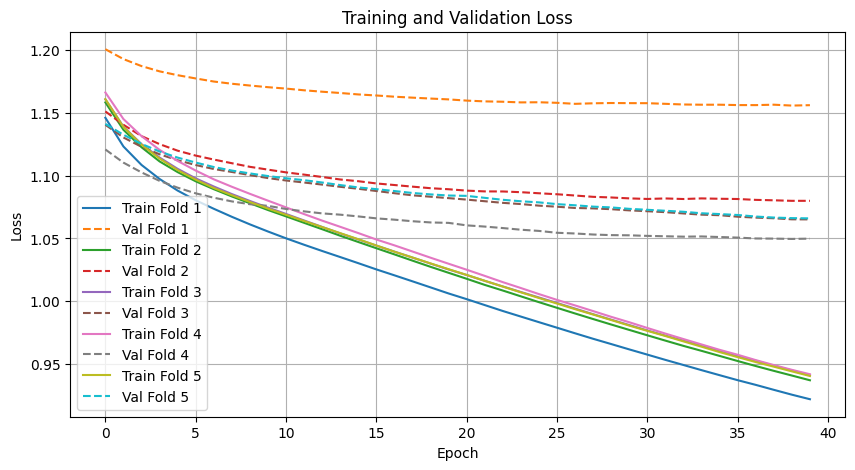

In [9]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
for fold in range(len(eval_stats['loss']['train'])):
    plt.plot(range(epochs), eval_stats['loss']['train'][fold], label=f'Train Fold {fold + 1}')
    plt.plot(range(epochs), eval_stats['loss']['val'][fold], label=f'Val Fold {fold + 1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.show()

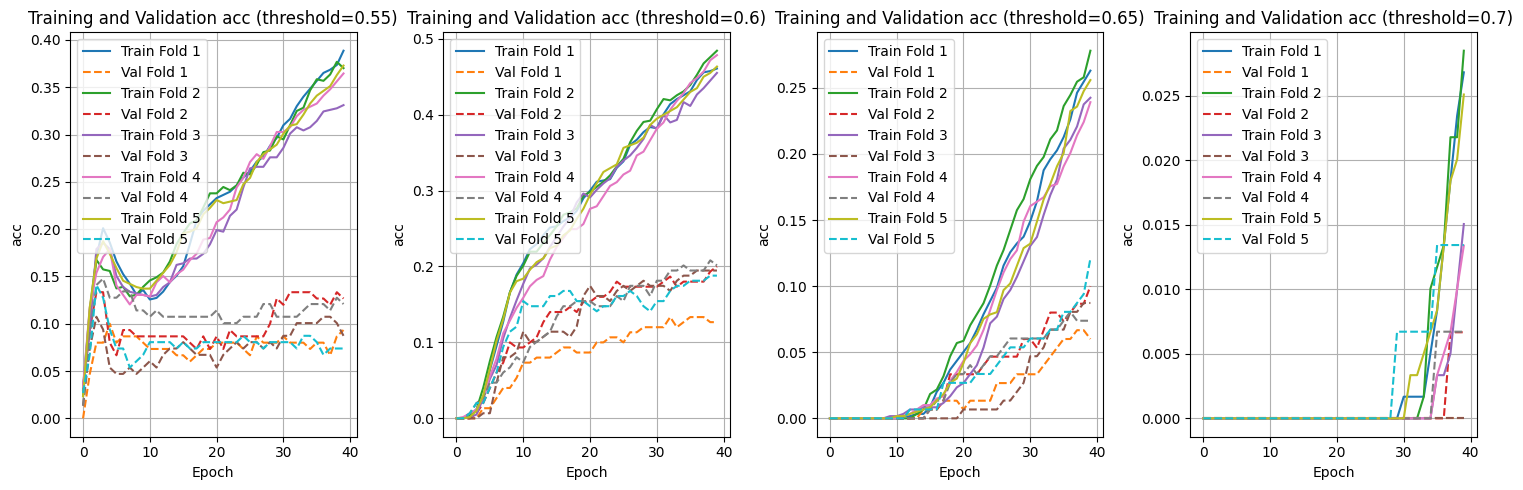

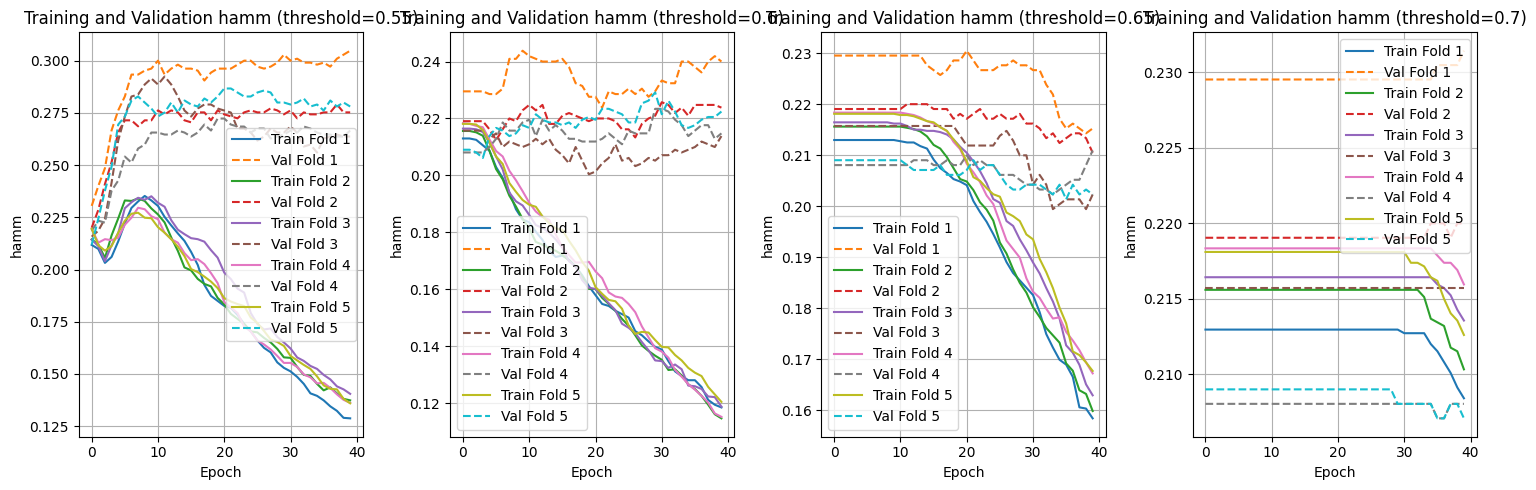

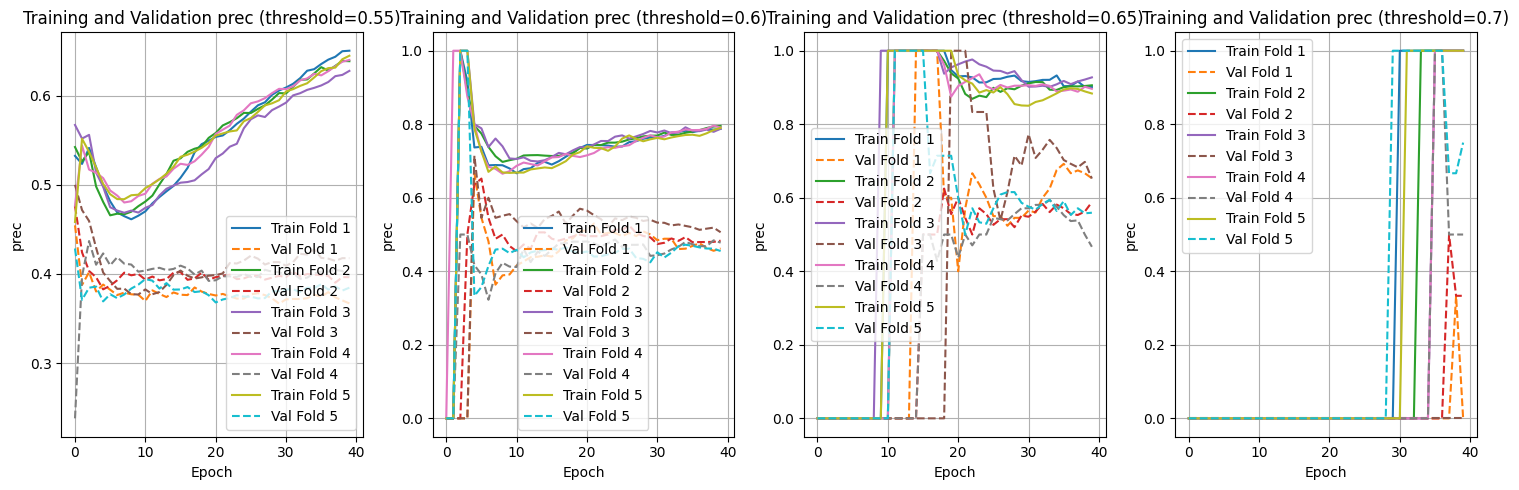

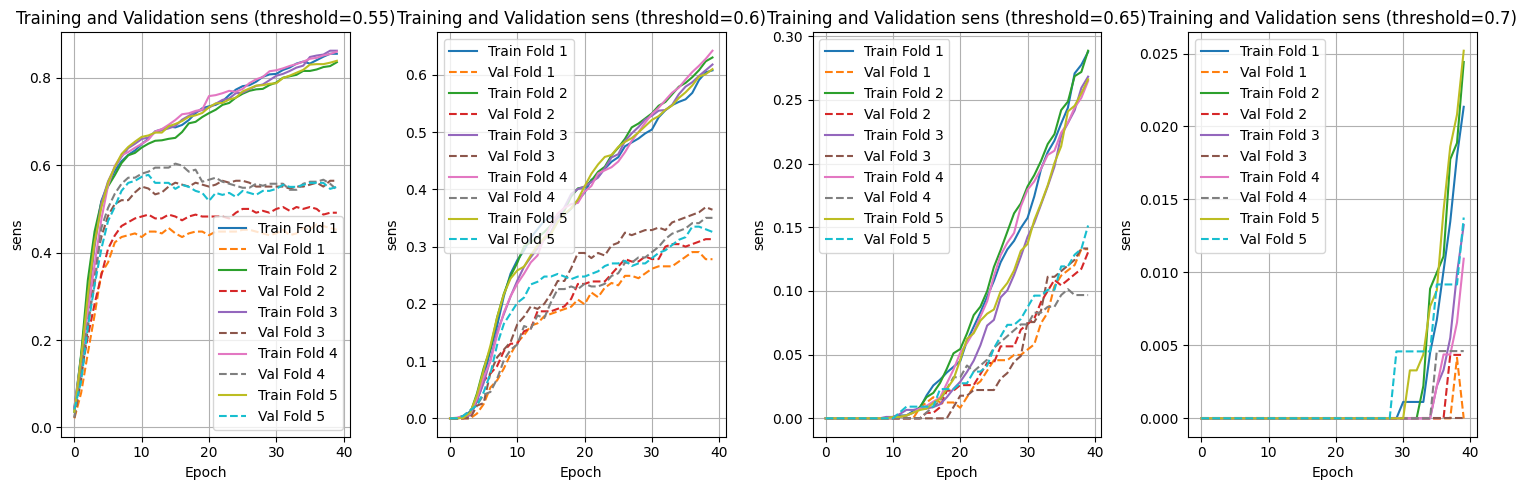

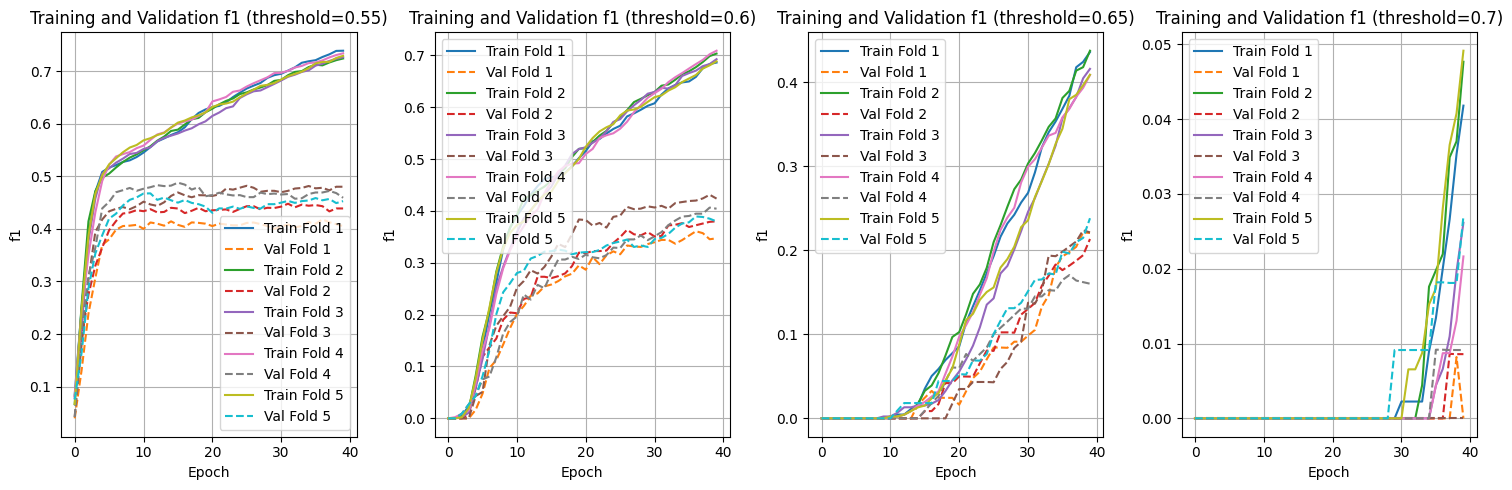

In [10]:
# Plotting
plot_metrics = METRICS.copy()
plot_metrics.remove('aps')
for metric in plot_metrics:
    fig, axs = plt.subplots(1, len(THRESHOLDS), figsize=(15, 5))
    for idx, t in enumerate(THRESHOLDS):
        train_stats_t = eval_stats[metric]['train'][t]
        val_stats_t = eval_stats[metric]['val'][t]

        for fold in range(len(train_stats_t)):
            axs[idx].plot(range(epochs), train_stats_t[fold], label=f'Train Fold {fold + 1}')
            axs[idx].plot(range(epochs), val_stats_t[fold], label=f'Val Fold {fold + 1}', linestyle='--')
        axs[idx].set_title(f'Training and Validation {metric} (threshold={t})')
        axs[idx].set_xlabel('Epoch')
        axs[idx].set_ylabel(f'{metric}')
        axs[idx].grid(True)
        # axs[idx].legend(loc='upper left')
        axs[idx].legend()


    plt.tight_layout()
    plt.show()


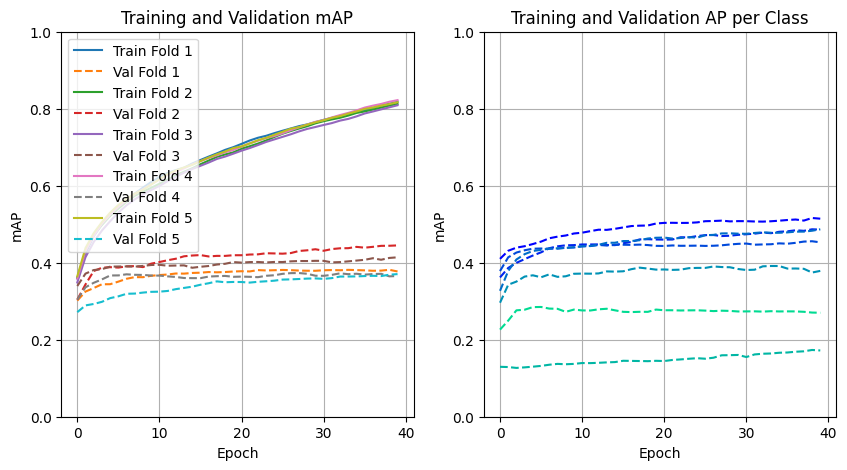

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


train_stats_t = np.array(eval_stats['aps']['train'][t]).mean(axis=-1)
# print(np.array(train_stats_t).shape)
val_stats_t = np.array(eval_stats['aps']['val'][t]).mean(axis=-1)
# print(np.array(val_stats_t).shape)

for fold in range(len(train_stats_t)):
    axs[0].plot(range(epochs), train_stats_t[fold], label=f'Train Fold {fold + 1}')
    axs[0].plot(range(epochs), val_stats_t[fold], label=f'Val Fold {fold + 1}', linestyle='--')

axs[0].set_ylim([0,1])
axs[0].set_title(f'Training and Validation mAP')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('mAP')
axs[0].grid(True)
# axs[0].legend(loc='upper left')
axs[0].legend()





val_stats_t = np.array(eval_stats['aps']['val'][t]).mean(axis=0).T
# Determine the number of smells
num_smells = len(val_stats_t)

# Create a colormap
cmap = plt.cm.winter

# Plot each line with a different color from the colormap
for smell in range(num_smells):
    color = cmap(float(smell) / num_smells)  # Generate a color from the colormap
    axs[1].plot(range(epochs), val_stats_t[smell], label=f'Val Class {smell + 1}', linestyle='--', color=color)

axs[1].set_ylim([0,1])
axs[1].set_title(f'Training and Validation AP per Class')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('mAP')
axs[1].grid(True)
# ax.legend(loc='lower left')

# Show or save the plot
plt.show()  # Or plt.savefig('your_plot.png')

In [14]:
for t in THRESHOLDS:
    print(f'----- Mean t = {t} -----')
    for metric in METRICS:
        val_stats_t = np.array(eval_stats[metric]['val'][t]).mean(axis=0)
        if metric == 'aps':
            metric = 'mAP'
            val_stats_t = val_stats_t.mean(axis=-1)

        print(f'{metric}:\t', val_stats_t[-1])

    print()

aps = np.array(eval_stats['aps']['val'][t]).mean(axis=0)[-1]
print(f'mAP:\t', aps.mean(axis=-1))
print(f'aps:\t', aps)

----- Mean t = 0.55 -----
acc:	 0.1003758389261745
hamm:	 0.2776490891658677
prec:	 0.3926359069780122
sens:	 0.5204536934773056
f1:	 0.4472329597414307
mAP:	 0.394443677150429

----- Mean t = 0.6 -----
acc:	 0.1821118568232662
hamm:	 0.22296324704378395
prec:	 0.4769157816090669
sens:	 0.326282941920308
f1:	 0.3869609123943786
mAP:	 0.394443677150429

----- Mean t = 0.65 -----
acc:	 0.0883758389261745
hamm:	 0.20824928092042186
prec:	 0.5838918264431785
sens:	 0.12893970785339176
f1:	 0.21083749847860855
mAP:	 0.394443677150429

----- Mean t = 0.7 -----
acc:	 0.005360178970917226
hamm:	 0.2164602109300096
prec:	 0.31666666666666665
sens:	 0.0045435177815480714
f1:	 0.008948627621095138
mAP:	 0.394443677150429

mAP:	 0.394443677150429
aps:	 [0.51440707 0.48604473 0.45294928 0.48680463 0.37877137 0.17211254
 0.27001611]


In [13]:
----- ms_spectra_ord 194_features red_target -----
acc:	 0.1821118568232662
hamm:	 0.22296324704378395
prec:	 0.4769157816090669
sens:	 0.326282941920308
f1:	     0.3869609123943786
mAP:	 0.394443677150429


----- ms_spectra_ord 194_features all_target -----
acc:	 0.11483253588516747
hamm:	 0.17695374800637959
prec:	 0.5104590016537932
sens:	 0.3285787264896415
f1:	     0.39961422430907195
mAP:	 0.34090461928482446

SyntaxError: invalid decimal literal (1942482726.py, line 1)